# 📓 Data Acquisition and Loading Notebook
This notebook demonstrates how to load and visualize dynamic GeoTIFF features and a target variable from a local dataset structure used in the XGBoost pipeline.

### 🔧 Step 1: Import dependencies and define dataset variables and time range
We'll import the required modules and define the path to the dataset along with the names of dynamic features.

In [31]:
import argparse
import requests
import logging
from datetime import datetime
from pathlib import Path
import os
import re
import glob
import numpy as np
from osgeo import gdal
import errno
import fnmatch
import sys
import matplotlib.pyplot as plt
import imageio

parser = argparse.ArgumentParser(description='Downloading GeoTIFF data for XGboost machine learning.')

############# PARAMETERS FOR DATA DOWNLOADING ################
parser.add_argument('--static_api_url', type=str, default="https://terrabrasilis.dpi.inpe.br/stac-api/v1",
                    help='Data url')   
parser.add_argument('--time_range', type=str, default=["20180101","20241216"],
                    help='Range time [begining, end]. Format yyyymmbb')    
parser.add_argument('--download', type=bool, default=False,
                    help='If True download the data, set to False if the data is already downloaded')
parser.add_argument('--root_path', type=str, default='C:/PostDoc/meeting_project_brasil/Workshop_IBAMA/project_xgboost/data',
                    help='Path to the GeoTIFF file')    
parser.add_argument('--target_name', type=str, default='ArDS',
                    help='Name of the target variable to be predicted')
parser.add_argument('--dynamic', type=str, default=['ArDS',
                                                    'A7Q',
                                                    'AcAr',
                                                    'CtDS',
                                                    'DeAI',
                                                    'DeAr',
                                                    'NuAI',
                                                    'Nuvem',
                                                    'OcDS',
                                                    'PtDG',
                                                    'PtEM',
                                                    'Pr'],
                    help='Names of the dynamic features to be loaded')
parser.add_argument('--static', type=str, default=['ACCESSCITY',  
                                                        'ACCESSBEEF',  
                                                        'ACCESSSOY',  
                                                        'ACCESSSOY25',  
                                                        'ACCESSWOOD',  
                                                        'CONN_MKT',  
                                                        'CONCITY10',  
                                                        'CONCITY100',  
                                                        'DVD',  
                                                        'DRYMONTHS',  
                                                        'EFAMS_IND',  
                                                        'EFAMS_UC',  
                                                        'EFAMS_TI',  
                                                        'EFAMS_FPND',  
                                                        'EFAMS_CAR',  
                                                        'EFAMS_ASS',  
                                                        'EFAMS_APA',  
                                                        'RODOFIC',  
                                                        'RODNOFIC',  
                                                        'DISTURB',  
                                                        'DISTRIOS',  
                                                        'DISTPORT'],
                    help='Names of the static features to be loaded')

parser.add_argument('--add_biweek_info', type=bool, default=True,
                    help='If True add biweek number as feature')
parser.add_argument('--nb_biweek', type=int, default=3,
                    help='Total number of biweeks to consdier (current biweek + past biweek)')
parser.add_argument('--train_timesteps', type=str, default=["20180101","20221216"], 
                    help='Start and end date for training data. Format yyyymmb. Let empty ([]) in case not training is needed')
parser.add_argument('--validation_timesteps', type=int, default=["20230101","20231216"], 
                    help='Start and end date for validation data. Format yyyymmb. Let empty ([]) in case not training is needed')
parser.add_argument('--test_timesteps', type=int, default=["20240101","20241216"],
                    help='Start and end date for test data. Format yyyymmb')

args, unknown = parser.parse_known_args()


In [32]:
############## Defining auxiliary functions ################
def get(endpoint, params=None):
    response = requests.get(endpoint, params=params)
    if response.status_code == 200:
        return response.json()
    print(f"error: {response.text}")
    return None

def download_asset(url, download_path):
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(download_path, "wb") as file:
            for chunk in response.iter_content(chunk_size=8192):
                file.write(chunk)
        print(f"downloaded in {download_path}")
        return True
    print(f"error downloading file {url}: {response.text}")
    return False

def find_common_timesteps(data_path, feature_names):
    folders = os.listdir(data_path)
    
    
    feature_timesteps = {feature: [] for feature in feature_names}
    for f in folders:
        files = glob.glob(os.path.join(data_path,f, '*.tif'))
    
        for file in files:
            _, filename = os.path.split(file)
            feature, year, month, fortnight = re.match(r'([a-zA-Z0-9_]+)_?(\d{4})(\d{2})(\d{2}).tif', filename).groups()
            if feature in feature_names:
                feature_timesteps[feature].append((int(year), int(month), int(fortnight)))

    # Sort the time-steps for each feature
    for feature in feature_timesteps:
        feature_timesteps[feature].sort(key=lambda x: (x[0], x[1], x[2]))  # Sort by year, then month, then fortnight

    common_timesteps = set(feature_timesteps[feature_names[0]])
    for feature in feature_names[1:]:
        common_timesteps.intersection_update(feature_timesteps[feature])

    return sorted(list(common_timesteps))

def read_tiff(tiff_file):
    data = gdal.Open(tiff_file).ReadAsArray()
    return data


def load_geotiffs(data_path, feature_names, common_timesteps, quinzena=[], addmonth_info = False):
    feature_stacks = []

    for feature in feature_names:
        timestep_stacks = []

        for year, month, fortnight in common_timesteps:
            filename = f'{feature}{year}{month:02d}{fortnight:02d}.tif'
            file_path = os.path.join(data_path, f'{feature}', filename)

            if not os.path.exists(file_path):
                raise FileNotFoundError(f"File not found: {file_path}")

            timestep_stacks.append(file_path)

        #TODO: the [:98,:136] adjustment is provisional because some tif fliles have a diff size
        timestep_stacks = np.stack([read_tiff(x).astype('float32')[:98,:136] for x in timestep_stacks],axis=-1)
        
        feature_stacks.append(timestep_stacks)
        
    # add biweek info as raster
    if addmonth_info:
        cont = 0
        quin_stacks = []
        for year, month, fortnight in common_timesteps:
    
            quin_stacks.append(np.ones((timestep_stacks.shape[0],timestep_stacks.shape[1]))*quinzena[cont])
            cont+=1
    
        quin_stacks = np.stack(quin_stacks,axis=-1)
        
        feature_stacks.append(quin_stacks)

    # Assuming all features have the same spatial dimensions
    if len(feature_names) > 1 or addmonth_info:
        return np.stack(feature_stacks, axis=-1)
    else:
        return feature_stacks[0]
    
def find_files_with_extension(directory, extension):
    matching_files = []

    # Walk through the directory and its subdirectories
    for root, dirs, files in os.walk(directory):
        for file in files:
            # Check if the file matches the specified extension
            if fnmatch.fnmatch(file, '*' + extension):
                # Add the file to the list
                matching_files.append(os.path.join(root, file))

    return matching_files
    
def load_statics(data_path, feature_names, dynamic_array):
    feature_stacks = []
    
    all_files = find_files_with_extension(data_path, '.tif')

    for feature in feature_names:
        file_path = [x for x in all_files if feature in x]
        
        if len(file_path) < 1:
            raise FileNotFoundError(f"File not found: {file_path}")
            
        static_var = read_tiff(file_path[0])
        if len(static_var.shape)>2:
            feature_stacks.append(np.rollaxis(static_var,0,3))
        else:
            feature_stacks.append(static_var[:, :, np.newaxis])
            
    #### static array to dynamic array 
    feature_stacks = np.concatenate(feature_stacks, axis=-1)
    
    if len(dynamic_array.shape) == 3:
        dynamic_array = dynamic_array[:, :, :, np.newaxis]
       
    feature_stacks = feature_stacks[:, :, np.newaxis, :]
    feature_stacks = np.repeat(feature_stacks, dynamic_array.shape[2], axis=2)
    
    dynamic_array = np.concatenate((dynamic_array,feature_stacks), axis=-1)
    
    return dynamic_array


def split_data(inputs, targets, train_range, val_range, test_range, common_timesteps):
    
    list_times = np.ones(6).astype('uint8')*(-1)
    cont_ind= 0

    for y,m,d in common_timesteps:
        strtime = f'{y}{m:02d}{d:02}'
        if (strtime >= train_range[0]) and (strtime <= train_range[1]):
            
            if list_times[0] == -1:
                list_times[0] = cont_ind
            else:
                list_times[1] = cont_ind

        elif (strtime >= val_range[0]) and (strtime <= val_range[1]):
            
            if list_times[2] == -1:
                list_times[2] = cont_ind-1
            else:
                list_times[3] = cont_ind

        elif (strtime >= test_range[0]) and (strtime <= test_range[1]):
            
            if list_times[4] == -1:
                list_times[4] = cont_ind-1
            else:
                list_times[5] = cont_ind+1
        
        cont_ind+=1
        
    
    train_inputs = inputs[:, :, list_times[0]:list_times[1]].copy().astype('float32')
    train_targets = targets[:, :, list_times[0]:list_times[1]].copy().astype('float32')

    val_inputs = inputs[:, :, list_times[2]:list_times[3]].copy().astype('float32')
    val_targets = targets[:, :, list_times[2]:list_times[3]].copy().astype('float32')

    test_inputs = inputs[:, :, list_times[4]:list_times[5]].copy().astype('float32')
    test_targets = targets[:, :, list_times[4]:list_times[5]].copy().astype('float32')

    return train_inputs, train_targets, val_inputs, val_targets, test_inputs, test_targets


### 🌐 Step 2: Download Data from Remote Server (STAC API)
This step retrieves dynamic and static GeoTIFF assets from a remote STAC-compliant API (e.g., Terrabrasilis). It queries available collections, selects the desired assets based on a date range, and downloads them into a structured local folder.

In [33]:
if args.download: 

    endpoint = f"{args.static_api_url}/collections/collection1"
    collection = get(endpoint=endpoint)
    assets = collection["item-assets"]
    for key in assets:
        asset = assets[key]
        print(f"\nasset: {assets[key]['title']} - {assets[key]['description']}")

    endpoint = f"{args.static_api_url}/search"
    
    beg = datetime(int(args.time_range[0][:4]), int(args.time_range[0][4:6]), int(args.time_range[0][6:]))
    end = datetime(int(args.time_range[1][:4]), int(args.time_range[1][4:6]), int(args.time_range[1][6:]))
    
    params = {
    "collections": ["collection1"],
    "datetime_range": beg.strftime("%Y-%m-%d")+'/'+end.strftime("%Y-%m-%d")  # correct format
    }
    
    items = get(endpoint=endpoint, params=params)
    items = items['features']
    
    root_download_dir = Path(f"{args.root_path}/{beg.strftime('%Y%m%d')}_{end.strftime('%Y%m%d')}")

    print("Downloading ......")
    for item in items:
        properties = item['properties']
        print(f"\nitem: {item['id']} - {properties['datetime']} - {list(item['assets'].keys())}")
        for name, values in item['assets'].items():
            url = values['href']
            print(f"\ndownloading {values['href']} ...")
        
            download_dir = root_download_dir / name
            download_dir.mkdir(exist_ok=True, parents=True)
            download_path = download_dir / Path(url).name
            download_asset(url=url, download_path=download_path)
            
    
else:
    beg = datetime(int(args.time_range[0][:4]), int(args.time_range[0][4:6]), int(args.time_range[0][6:]))
    end = datetime(int(args.time_range[1][:4]), int(args.time_range[1][4:6]), int(args.time_range[1][6:]))
    
    root_download_dir = Path(f"{args.root_path}/{beg.strftime('%Y%m%d')}_{end.strftime('%Y%m%d')}")

### ⏳ Step 3: Find common timesteps across all dynamic features
This ensures that we only use timepoints where all features are present.

In [34]:
# Find common timesteps
common_timesteps = find_common_timesteps(root_download_dir, args.dynamic)
print("Common timesteps found:", len(common_timesteps))
print(common_timesteps)


Common timesteps found: 165
[(2018, 1, 16), (2018, 2, 1), (2018, 2, 16), (2018, 3, 1), (2018, 3, 16), (2018, 4, 1), (2018, 4, 16), (2018, 5, 1), (2018, 5, 16), (2018, 6, 1), (2018, 6, 16), (2018, 7, 1), (2018, 7, 16), (2018, 8, 1), (2018, 8, 16), (2018, 9, 1), (2018, 9, 16), (2018, 10, 1), (2018, 10, 16), (2018, 11, 1), (2018, 11, 16), (2018, 12, 1), (2018, 12, 16), (2019, 1, 1), (2019, 1, 16), (2019, 2, 1), (2019, 2, 16), (2019, 3, 16), (2019, 4, 1), (2019, 4, 16), (2019, 5, 1), (2019, 5, 16), (2019, 6, 1), (2019, 6, 16), (2019, 7, 1), (2019, 7, 16), (2019, 8, 1), (2019, 8, 16), (2019, 9, 1), (2019, 9, 16), (2019, 10, 1), (2019, 10, 16), (2019, 11, 1), (2019, 11, 16), (2019, 12, 1), (2019, 12, 16), (2020, 1, 1), (2020, 1, 16), (2020, 2, 1), (2020, 2, 16), (2020, 3, 1), (2020, 3, 16), (2020, 4, 1), (2020, 4, 16), (2020, 5, 1), (2020, 5, 16), (2020, 6, 1), (2020, 6, 16), (2020, 7, 1), (2020, 7, 16), (2020, 8, 1), (2020, 8, 16), (2020, 9, 1), (2020, 10, 1), (2020, 10, 16), (2020, 11, 1),

### 🗓️ Step 4: Encode biweekly values
This creates a biweekly index that can be added as an extra raster layer.

In [35]:
# Compute biweekly feature encoding
biweek_feature = [(m*2)-1 if q == 1 else m*2 for y, m, q in common_timesteps]


### 🧱 Step 5: Load the dynamic features into a single numpy array
Features will be loaded and stacked into a 4D array: [rows, cols, timesteps, features].

In [36]:

# Load dynamic features stack
stacked_array = load_geotiffs(
    data_path=root_download_dir,
    feature_names=args.dynamic,
    common_timesteps=common_timesteps,
    quinzena=biweek_feature,
    addmonth_info=args.add_biweek_info
)

r, c, t, f = stacked_array.shape
print(f"Shape of dynamic feature stack: ROWS {r}, COLUMNS {c}, TIME-STEPS {t}, FEATURES {f}")


Shape of dynamic feature stack: ROWS 98, COLUMNS 136, TIME-STEPS 165, FEATURES 13


### 🖼️ Step 6: Visualize one feature at N chosen time steps
This helps verify the raster is loaded and looks correct.

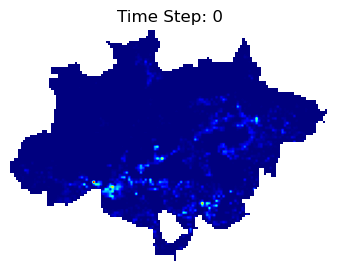

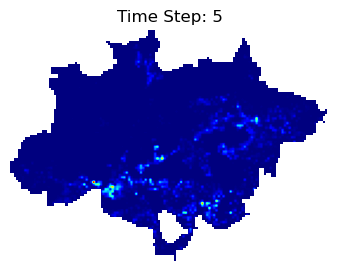

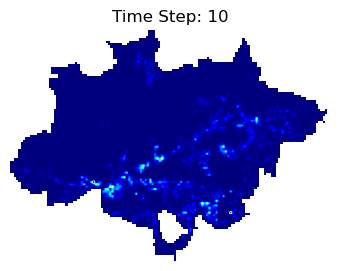

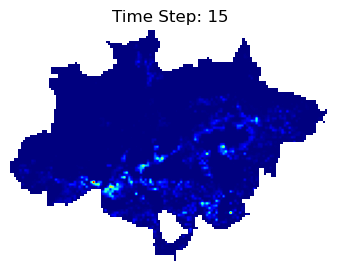

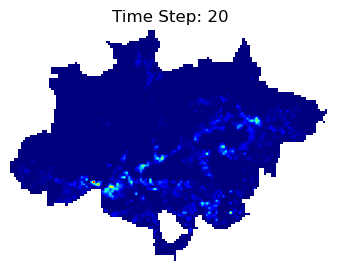

In [38]:
# Define time steps to visualize
time_steps = [0, 5, 10, 15, 20]  # You can modify this list as needed

for time_step in time_steps:
    tmp_array = stacked_array[:, :, time_step, 2].copy()
    tmp_array[tmp_array > 100] = np.nan  # Mask out values > 100

    plt.figure(figsize=(5, 3))
    plt.imshow(tmp_array, cmap='jet')
    plt.axis('off')
    plt.title(f'Time Step: {time_step}')
    plt.show()


### 🎯 Step 7: Load and inspect the target variable
The target raster is usually a single band per timestep.

Shape of target variable stack: ROWS 98, COLUMNS 136, TIME-STEPS 165


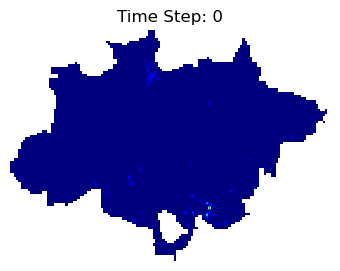

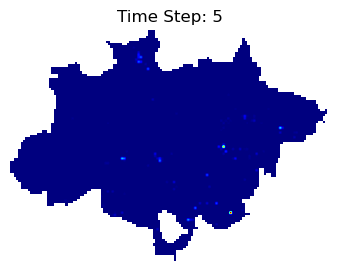

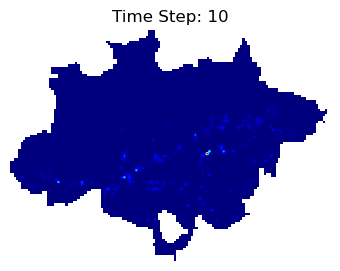

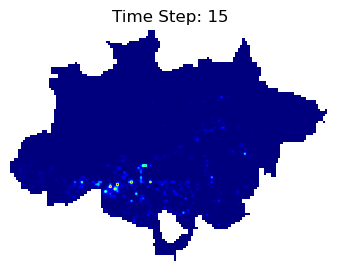

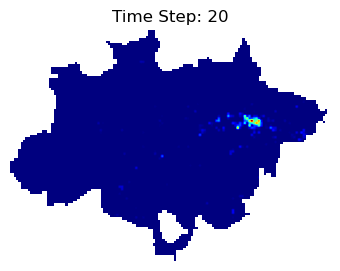

In [39]:
# Load and inspect the target stack
stacked_target = load_geotiffs(
    data_path=root_download_dir,
    feature_names=[args.target_name],
    common_timesteps=common_timesteps
)

r, c, t = stacked_target.shape
print(f"Shape of target variable stack: ROWS {r}, COLUMNS {c}, TIME-STEPS {t}")

# Define time steps to visualize
time_steps = [0, 5, 10, 15, 20]  # You can modify this list as needed

for time_step in time_steps:
    tmp_array = stacked_target[:, :, time_step].copy()
    tmp_array[tmp_array > 100] = np.nan  # Mask out values > 100

    plt.figure(figsize=(5, 3))
    plt.imshow(tmp_array, cmap='jet')
    plt.axis('off')
    plt.title(f'Time Step: {time_step}')
    plt.show()


### 📊 Step 8: Add past beweeks and static data

In [40]:
##### add  past beweeks if defined
if args.nb_biweek>1:
    logging.info("Adding past nb_biweek-1 biweeks ...")
    biweek_array = [stacked_array[:,:,args.nb_biweek-1:-1]]
    cont = 2
    for i in range(args.nb_biweek)[1:]:
        biweek_array.append(stacked_array[:,:,args.nb_biweek-1-i:-cont,0][...,np.newaxis])
        cont+=1

    stacked_array = np.concatenate(biweek_array, axis=-1)
else:
    stacked_array = stacked_array[:,:,:-1]
    

##### add static data is defined
if len(args.static) > 0:
    logging.info("Adding static data ...")
    stacked_array = load_statics(root_download_dir, args.static, stacked_array)

r, c, t, f = stacked_array.shape
print(f"Final shape of the data: ROWS {r}, COLUMNS {c}, TIME-STEPS {t}, FEATURES {f}")

Final shape of the data: ROWS 98, COLUMNS 136, TIME-STEPS 162, FEATURES 37


### 📊 Step 9: Split data in training and testing sets

In [41]:
stacked_target = stacked_target[:, :, args.nb_biweek:]

train_inputs, train_targets, val_inputs, val_targets, test_inputs, test_targets = split_data(
    stacked_array, stacked_target, args.train_timesteps, args.validation_timesteps, 
    args.test_timesteps,common_timesteps[args.nb_biweek-1:-1]
)

print(f"Training shape: ROWS {train_inputs.shape[0]}, COLUMNS {train_inputs.shape[1]}, TIME-STEPS {train_inputs.shape[2]}, FEATURES {train_inputs.shape[3]}")
print(f"Validation shape: ROWS {val_inputs.shape[0]}, COLUMNS {val_inputs.shape[1]}, TIME-STEPS {val_inputs.shape[2]}, FEATURES {val_inputs.shape[3]}")
print(f"Test shape: ROWS {test_inputs.shape[0]}, COLUMNS {test_inputs.shape[1]}, TIME-STEPS {test_inputs.shape[2]}, FEATURES {test_inputs.shape[3]}")

Training shape: ROWS 98, COLUMNS 136, TIME-STEPS 114, FEATURES 37
Validation shape: ROWS 98, COLUMNS 136, TIME-STEPS 24, FEATURES 37
Test shape: ROWS 98, COLUMNS 136, TIME-STEPS 24, FEATURES 37


### 📊 Step 8: Basic statistics for sanity checking
We inspect the distribution and ranges of both input and target arrays.


Feature ArDS:
 - Min: 0.0
 - Max: 74.4863052368164
 - Mean: 0.04324962659243447
 - Median: 0.0
 - Std: 0.35531448378702646


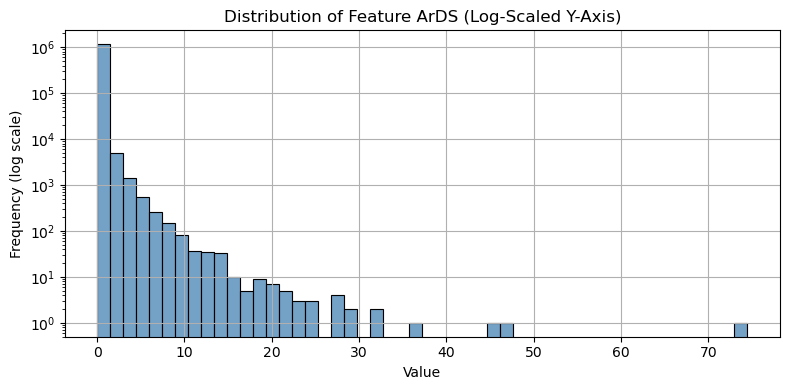


Feature A7Q:
 - Min: 0.0
 - Max: 78.97724914550781
 - Mean: 0.0595005344535448
 - Median: 0.0
 - Std: 0.4344190879990747


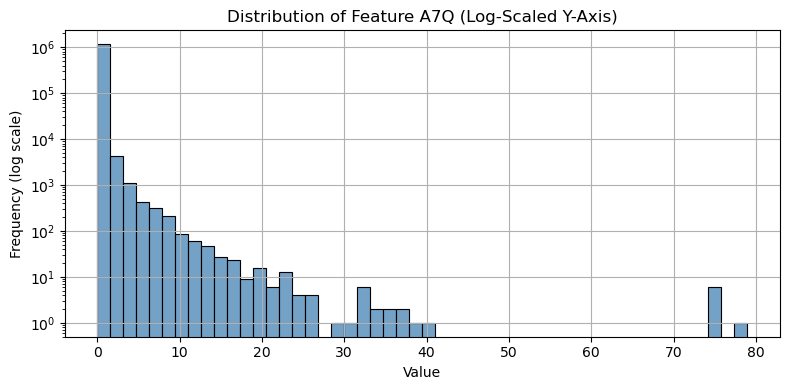


Feature AcAr:
 - Min: 0.0
 - Max: 322.94293212890625
 - Mean: 4.212837961961414
 - Median: 0.0
 - Std: 13.755372534426952


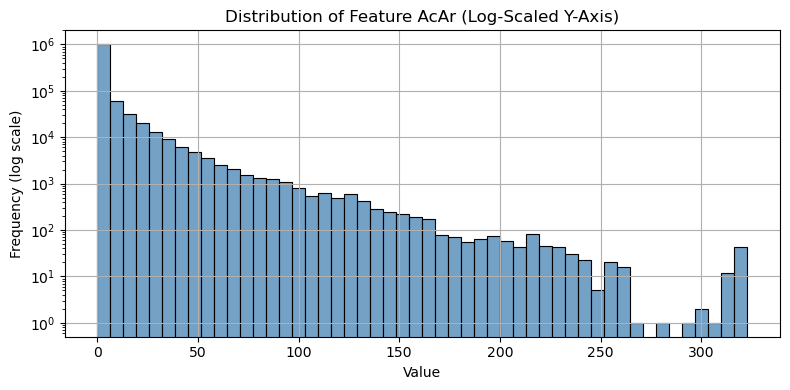


Feature CtDS:
 - Min: 0.0
 - Max: 69.0
 - Mean: 0.22260989259652053
 - Median: 0.0
 - Std: 1.296581360623855


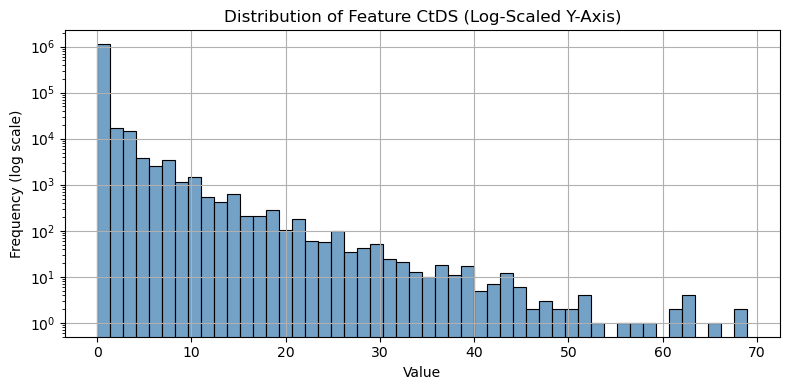


Feature DeAI:
 - Min: -50.0
 - Max: 55.0
 - Mean: 0.0023319995423098667
 - Median: 0.0
 - Std: 0.45754899212081057


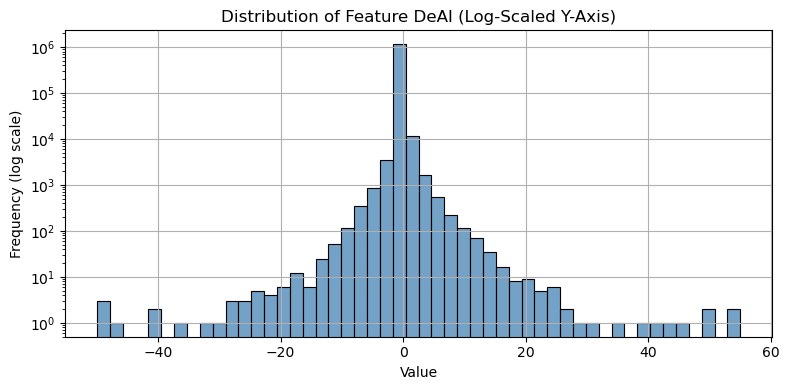


Feature DeAr:
 - Min: -74.4863052368164
 - Max: 74.4863052368164
 - Mean: 0.00012959007840223643
 - Median: 0.0
 - Std: 0.42367795908442674


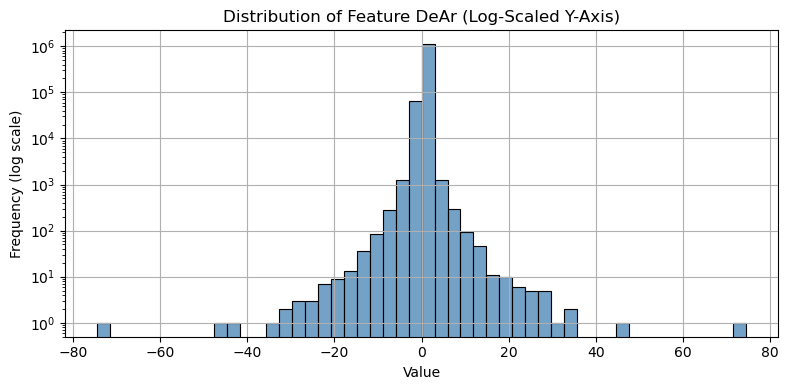


Feature NuAI:
 - Min: 0.0
 - Max: 97.0
 - Mean: 0.015374460548989069
 - Median: 0.0
 - Std: 0.27396077607657043


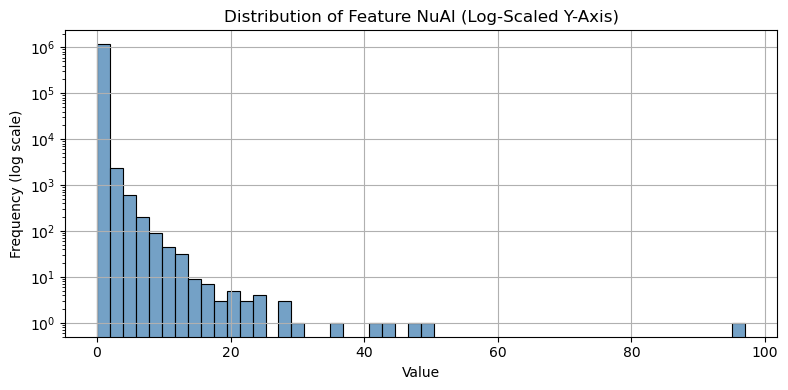


Feature Nuvem:
 - Min: 0.0
 - Max: 624.9999389648438
 - Mean: 152.06026133514018
 - Median: 13.967733383178711
 - Std: 223.92598636406876


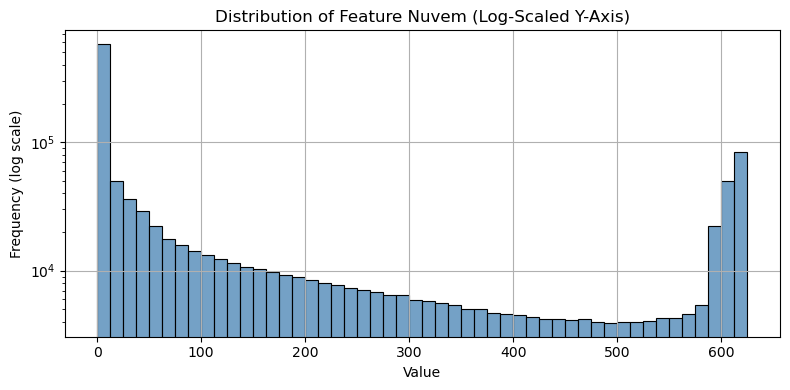


Feature OcDS:
 - Min: 0.0
 - Max: 1.0
 - Mean: 0.07173097383822703
 - Median: 0.0
 - Std: 0.25804193696073247


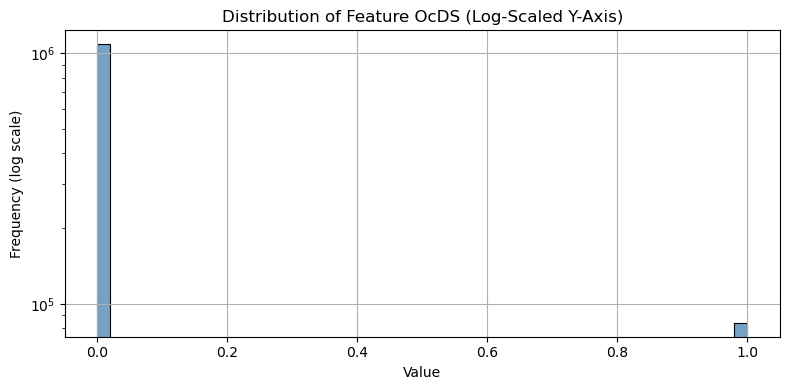


Feature PtDG:
 - Min: 0.0
 - Max: 38.509822845458984
 - Mean: 0.007977697252120594
 - Median: 0.0
 - Std: 0.2217024839605408


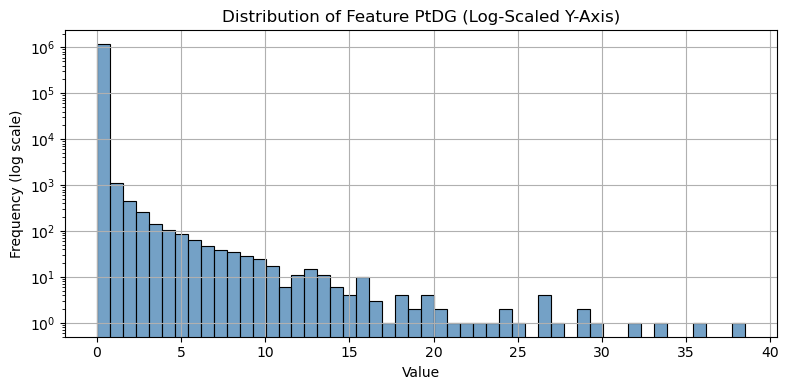


Feature PtEM:
 - Min: 0.0
 - Max: 10.064380645751953
 - Mean: 0.00044529981759826174
 - Median: 0.0
 - Std: 0.028259199452595998


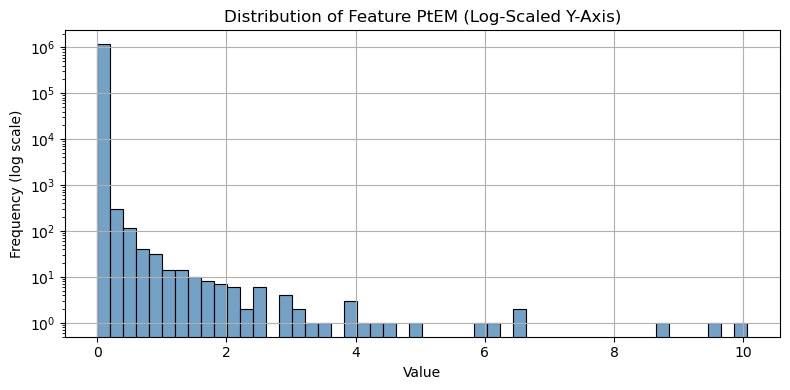


Feature Pr:
 - Min: 0.0
 - Max: 6261.75
 - Mean: 379.6473519135461
 - Median: 273.375
 - Std: 382.16894557285013


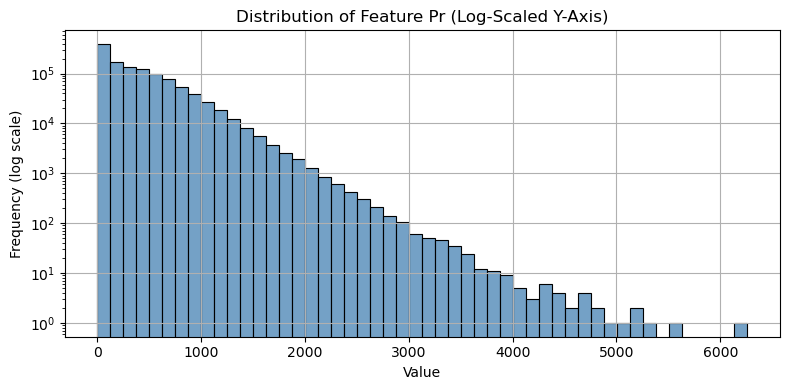


Feature NbQ:
 - Min: 1.0
 - Max: 24.0
 - Mean: 12.635802469135802
 - Median: 13.0
 - Std: 6.802102228459498


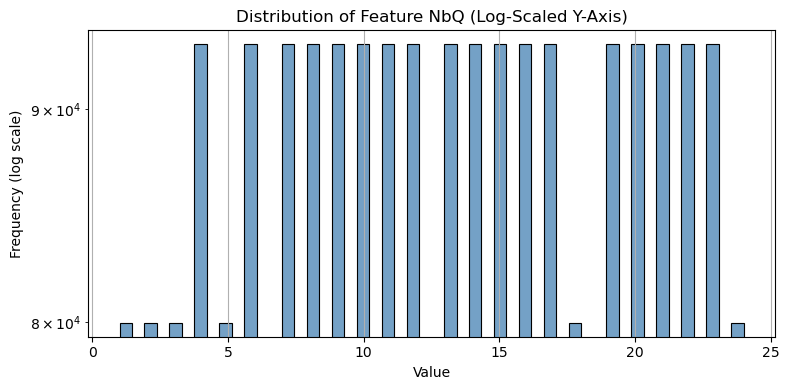


Feature ArDS_Q2:
 - Min: 0.0
 - Max: 74.4863052368164
 - Mean: 0.043270062406283887
 - Median: 0.0
 - Std: 0.3553666702350551


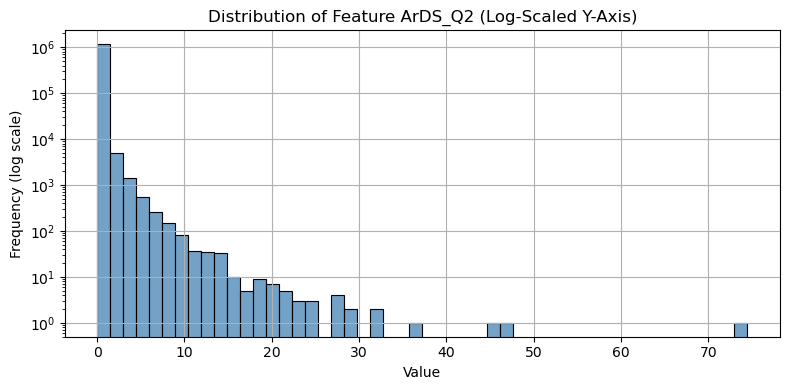


Feature ArDS_Q3:
 - Min: 0.0
 - Max: 74.4863052368164
 - Mean: 0.04331554283410332
 - Median: 0.0
 - Std: 0.3558211030115168


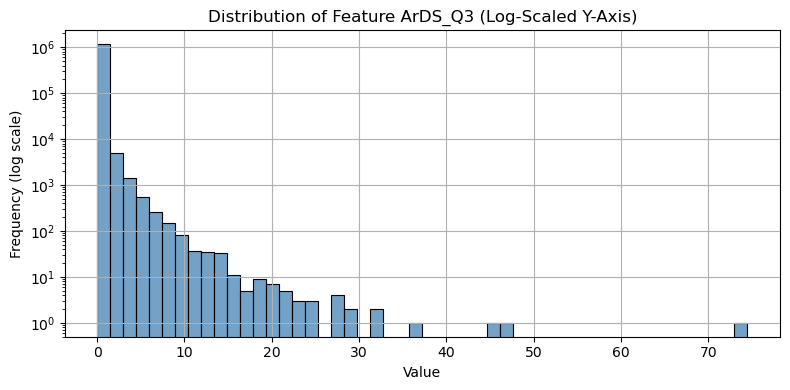


Feature ACCESSCITY:
 - Min: 0.0
 - Max: 644.0
 - Mean: 591.3753652060851
 - Median: 607.0
 - Std: 70.42461651251999


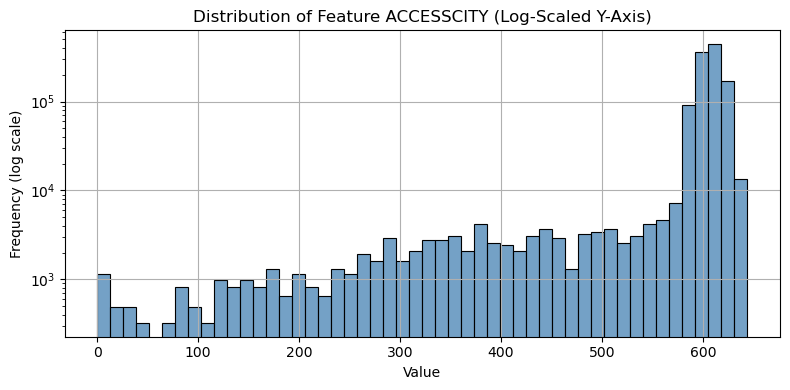


Feature ACCESSBEEF:
 - Min: 0.26194748282432556
 - Max: 644.0
 - Mean: 591.7167535006737
 - Median: 607.0
 - Std: 69.38531650980066


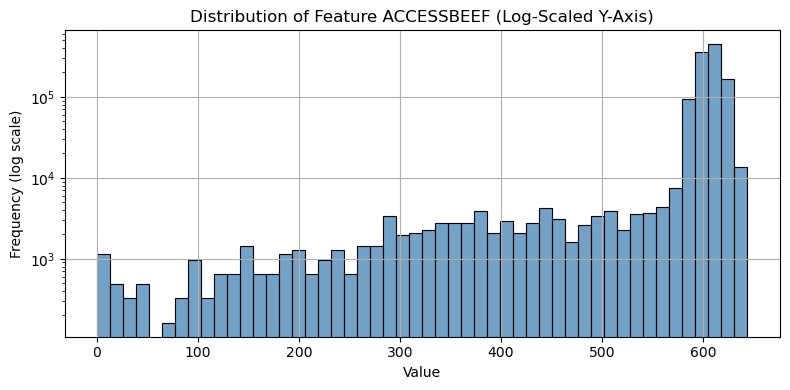


Feature ACCESSSOY:
 - Min: 0.0
 - Max: 644.0
 - Mean: 591.3753652060851
 - Median: 607.0
 - Std: 70.42461651251999


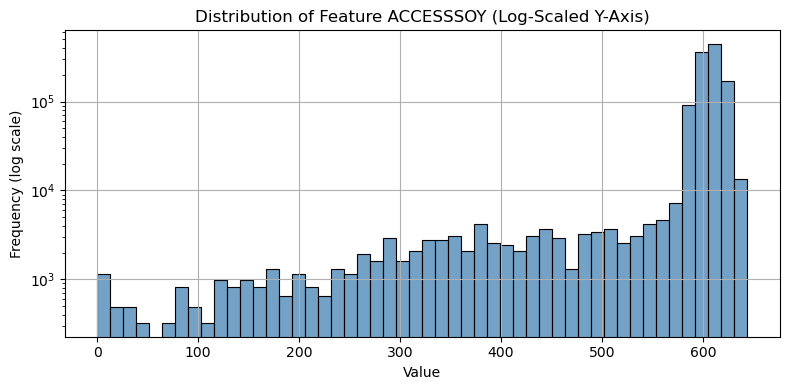


Feature ACCESSSOY25:
 - Min: 0.0
 - Max: 644.0
 - Mean: 591.3753652060851
 - Median: 607.0
 - Std: 70.42461651251999


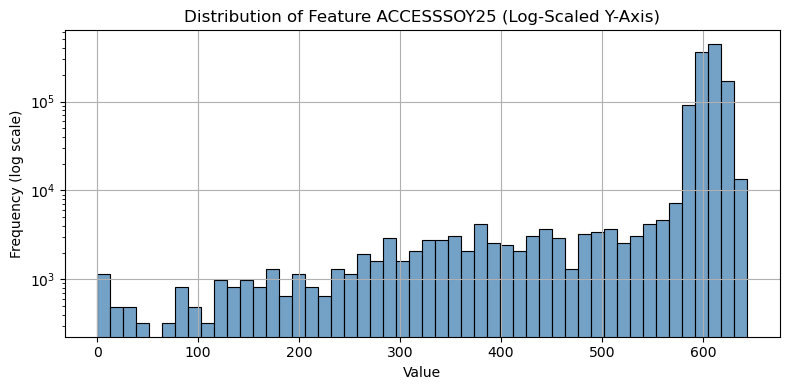


Feature ACCESSWOOD:
 - Min: 0.0
 - Max: 644.0
 - Mean: 591.3753652060851
 - Median: 607.0
 - Std: 70.42461651251999


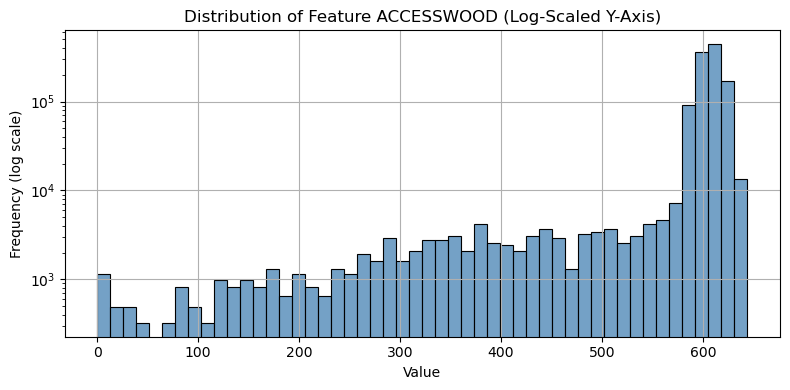


Feature CONN_MKT:
 - Min: 3347.8193359375
 - Max: 1883244.875
 - Mean: 509270.849832543
 - Median: 411858.90625
 - Std: 379140.4258723106


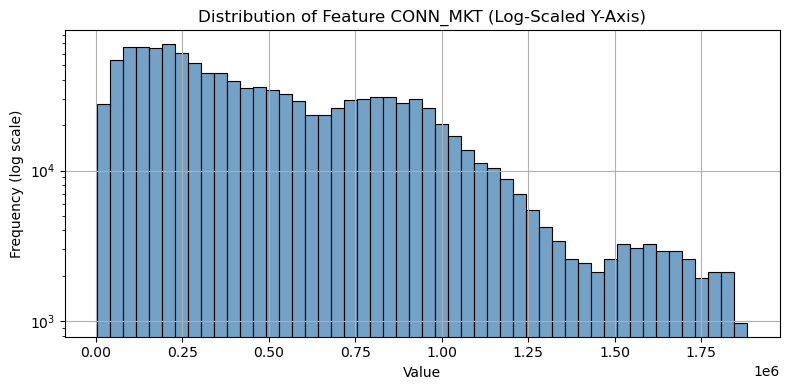


Feature CONCITY10:
 - Min: 950.96337890625
 - Max: 1000517.375
 - Mean: 181343.09179704386
 - Median: 112827.8671875
 - Std: 191741.1850891681


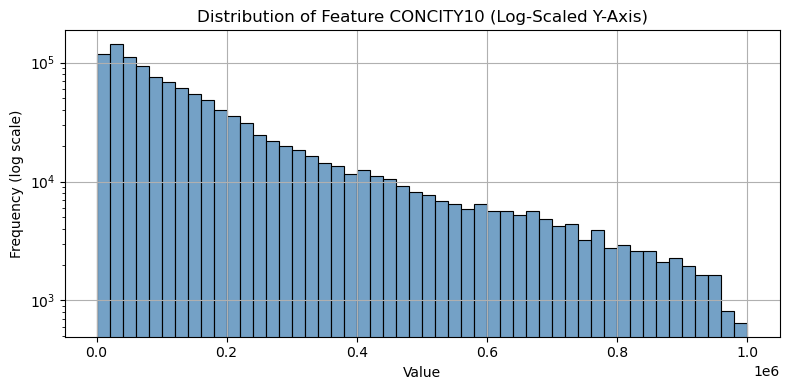


Feature CONCITY100:
 - Min: 4647.15625
 - Max: 1116402.375
 - Mean: 278811.3647091467
 - Median: 239351.703125
 - Std: 198706.28846965407


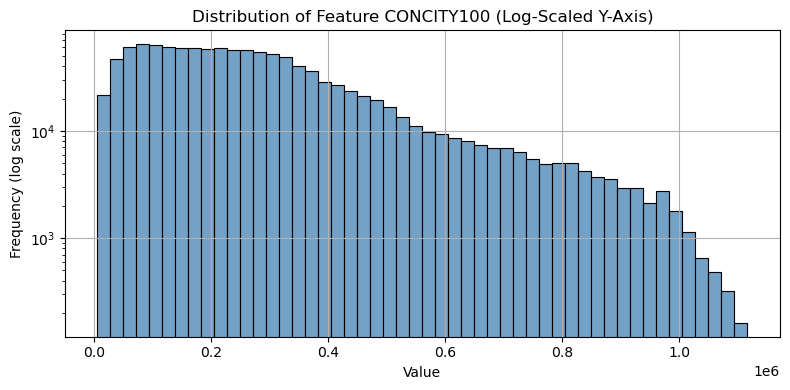


Feature DVD:
 - Min: -1.0
 - Max: 656.0126953125
 - Mean: 28.282188055987103
 - Median: 21.229106903076172
 - Std: 30.353427672889286


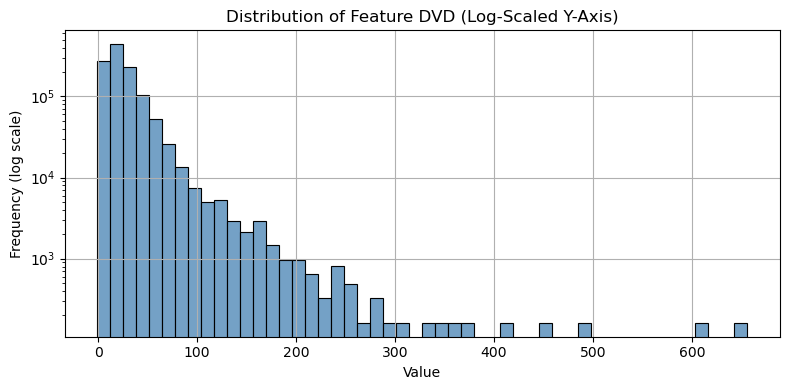


Feature DRYMONTHS:
 - Min: 0.0
 - Max: 999.0
 - Mean: 33.28441001521649
 - Median: 4.0
 - Std: 170.29927001756906


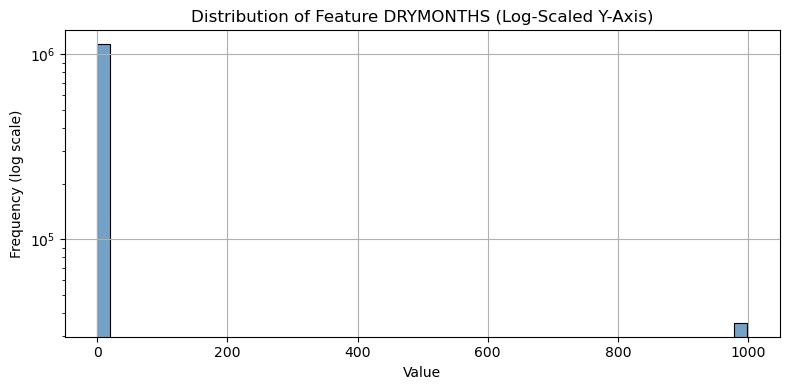


Feature EFAMS_IND:
 - Min: 0.0
 - Max: 1.0
 - Mean: 0.1527177821624122
 - Median: 0.029851360246539116
 - Std: 0.237527828253928


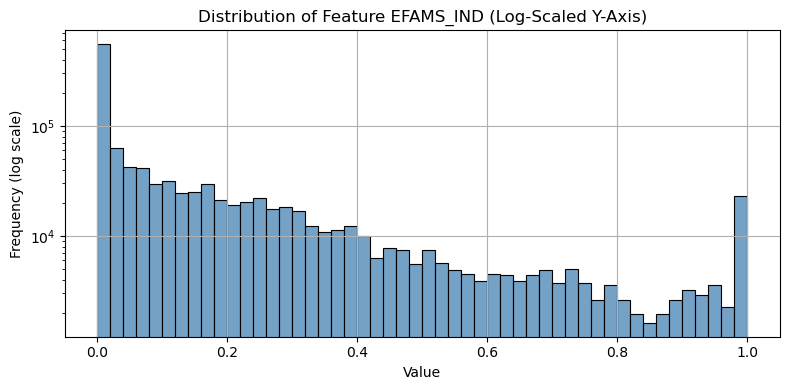


Feature EFAMS_UC:
 - Min: 0.0
 - Max: 1.0
 - Mean: 0.20884953453338795
 - Median: 0.0
 - Std: 0.3609662136796475


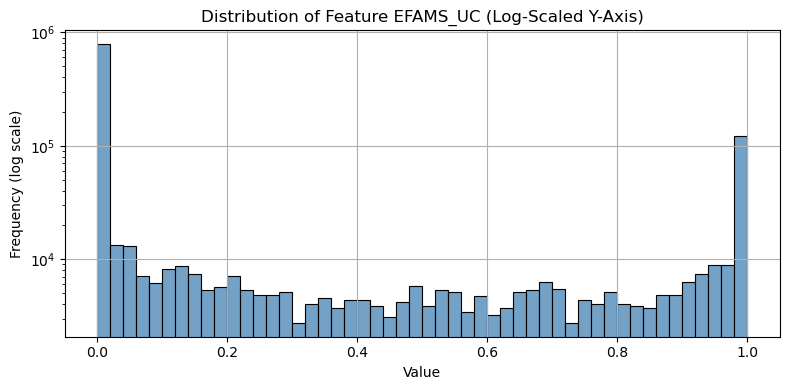


Feature EFAMS_TI:
 - Min: 0.0
 - Max: 1.0
 - Mean: 0.25147586488356977
 - Median: 0.0
 - Std: 0.3958377963301051


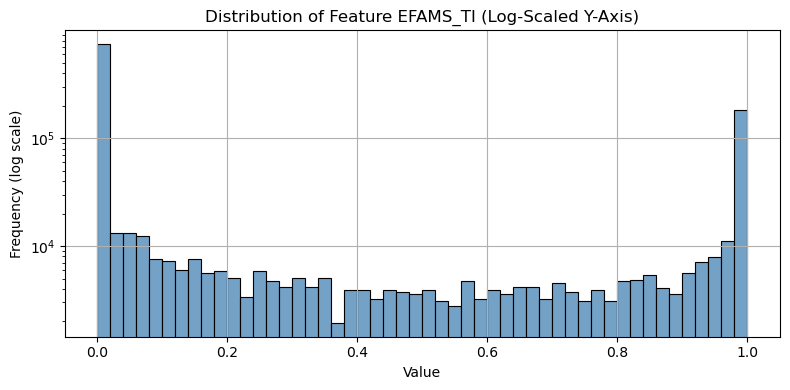


Feature EFAMS_FPND:
 - Min: 0.0
 - Max: 1.0
 - Mean: 0.11018757286053814
 - Median: 0.0001844599610194564
 - Std: 0.234165207792569


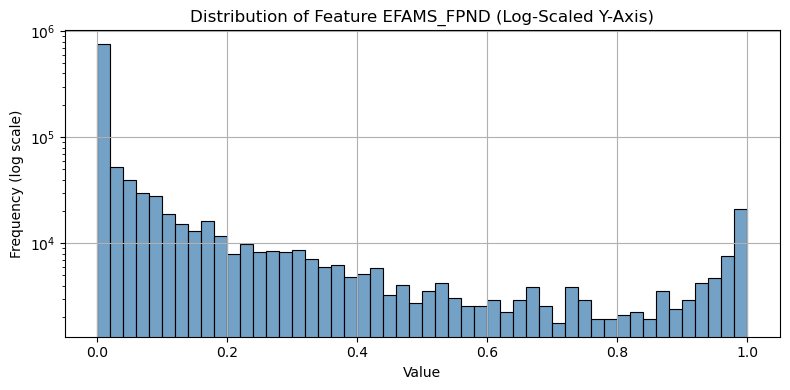


Feature EFAMS_CAR:
 - Min: 0.0
 - Max: 0.9986177682876587
 - Mean: 0.16317933437804363
 - Median: 0.0026352389249950647
 - Std: 0.24784830883252068


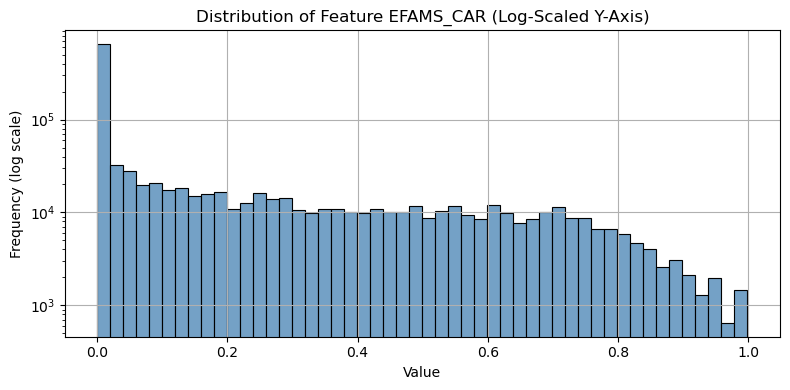


Feature EFAMS_ASS:
 - Min: 0.0
 - Max: 1.0
 - Mean: 0.07325380119333624
 - Median: 0.0
 - Std: 0.18637696984792426


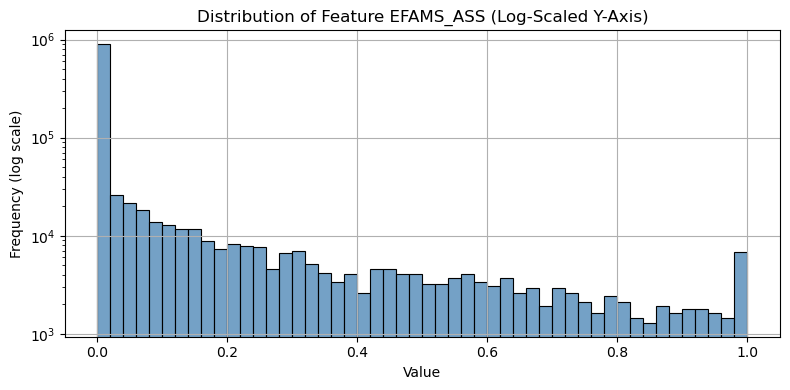


Feature EFAMS_APA:
 - Min: 0.0
 - Max: 1.0
 - Mean: 0.03867612925704996
 - Median: 0.0
 - Std: 0.1687134186388228


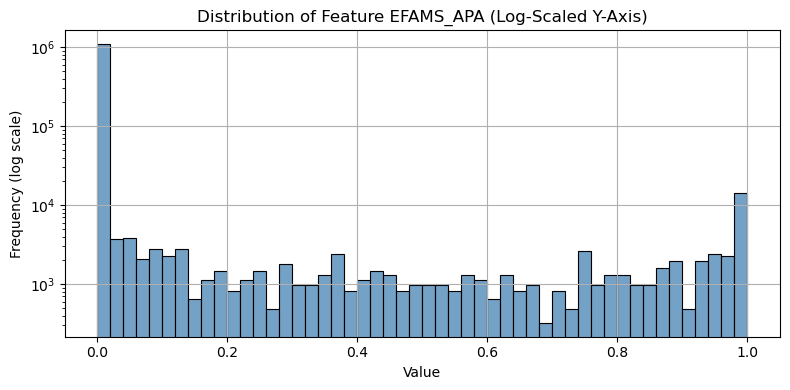


Feature RODOFIC:
 - Min: 61.51595687866211
 - Max: 516761.09375
 - Mean: 93020.73560136423
 - Median: 53990.4609375
 - Std: 103628.41468537315


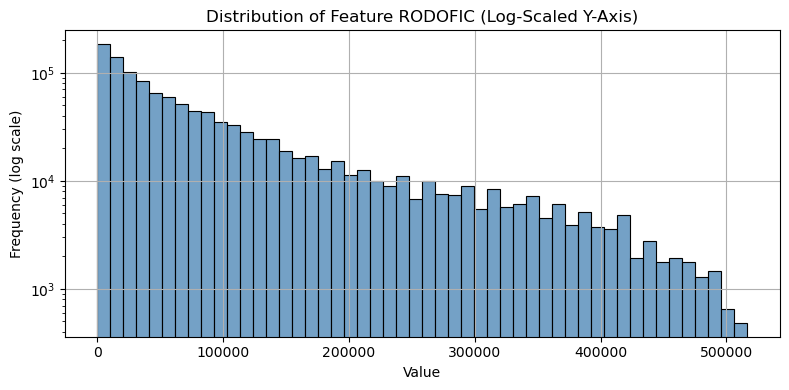


Feature RODNOFIC:
 - Min: 15.425993919372559
 - Max: 388224.5
 - Mean: 39434.91744846558
 - Median: 20646.53125
 - Std: 50893.53610243527


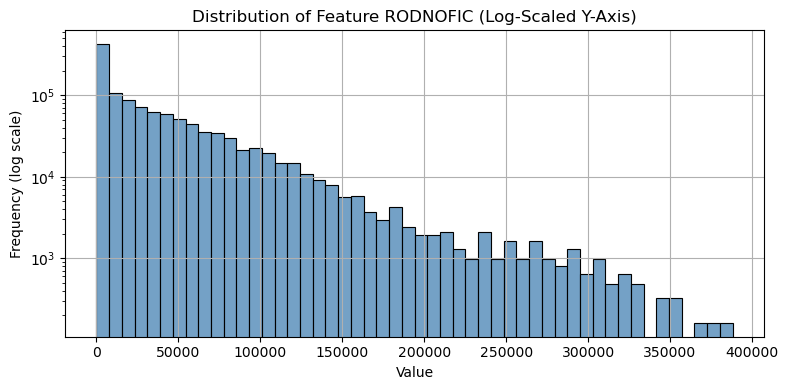


Feature DISTURB:
 - Min: 0.0
 - Max: 1090856.25
 - Mean: 285372.7158840748
 - Median: 243401.65625
 - Std: 209684.68476716563


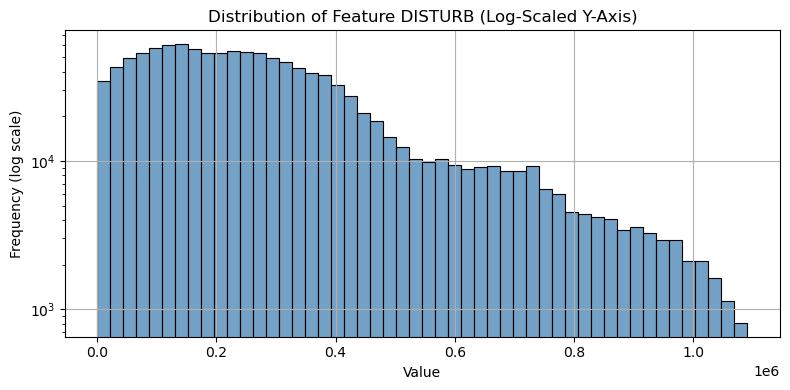


Feature DISTRIOS:
 - Min: 15.047713279724121
 - Max: 59574.1484375
 - Mean: 8258.33228661137
 - Median: 6399.0712890625
 - Std: 7290.846040781921


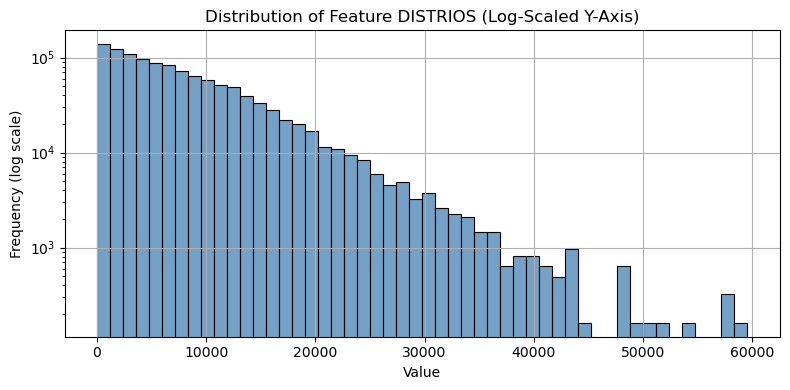


Feature DISTPORT:
 - Min: 2692.39794921875
 - Max: 1227491.625
 - Mean: 482264.07186140324
 - Median: 437458.21875
 - Std: 275951.5427621124


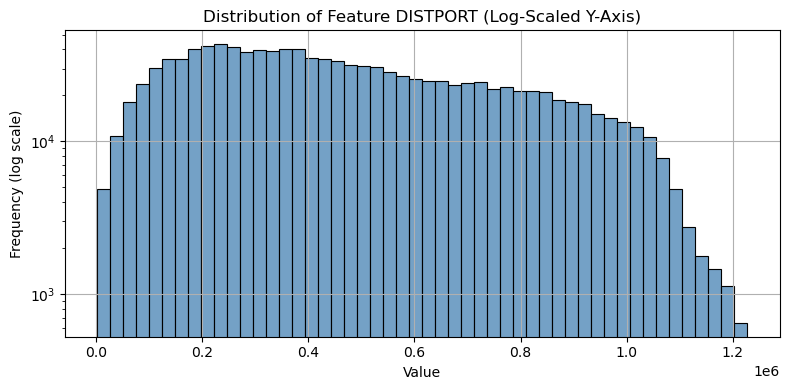

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

feature_names = args.dynamic.copy()
feature_names1 = feature_names
if args.add_biweek_info:
    feature_names.append('NbQ')
if args.nb_biweek > 1:
    for q in range(args.nb_biweek-1):
        feature_names.append(f'ArDS_Q{q+2}')
if len(args.static) > 0:
    feature_names.extend(args.static)

# Unpack the shape
rows, cols, time_steps, features = stacked_array.shape

# Compute statistics for each feature across all spatial and temporal dimensions
for f_idx in range(features):
    data = stacked_array[:, :, :, f_idx].flatten()
    data = data[~np.isnan(data)]  # Remove NaNs
    data = data[data!=999999.0]

    print(f"\nFeature {feature_names[f_idx]}:")
    print(f" - Min: {np.min(data)}")
    print(f" - Max: {np.max(data)}")
    print(f" - Mean: {np.mean(data)}")
    print(f" - Median: {np.median(data)}")
    print(f" - Std: {np.std(data)}")

    # Plot histogram with log Y-axis
    plt.figure(figsize=(8, 4))
    sns.histplot(data, bins=50, kde=False, color='steelblue')
    plt.yscale('log')  # Apply log scale to Y-axis only
    plt.title(f'Distribution of Feature {feature_names[f_idx]} (Log-Scaled Y-Axis)')
    plt.xlabel('Value')
    plt.ylabel('Frequency (log scale)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()